In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from sklearn.cluster import KMeans

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
from core import SITE_NAMES, FREQ_GROUPS, RANDOM_STATES_FOR_SITES

from cli import get_file_paths
import plot
import pipeline
import activity_assembly as actvt

In [4]:
color_for_groups = {0: 'blue', 1: 'red', 2:'limegreen'}
label_for_groups = {0: 'LF1', 1: 'HF1', 2:'HF2'}

In [5]:
def classify_freq_groups_in_df(location_df, data_params, file_paths):
    if data_params['use_kmeans']:
        train_welch_data = pd.read_csv(f"{file_paths['generated_welch_dir']}/2022_{data_params['site_tag']}_top1_inbouts_welch_signals.csv", 
                                 index_col=0, low_memory=False)
        k = 3
        kmean_welch = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATES_FOR_SITES[data_params['site_tag']]).fit(train_welch_data)
        test_welch_data = pd.read_csv(f"{file_paths['generated_welch_dir']}/2022_{data_params['site_tag']}_top100_infile_welch_signals.csv", index_col=0, low_memory=False)
        predictions_on_all = pd.Series(kmean_welch.predict(test_welch_data))
        labelled_preds = predictions_on_all.map({0:'LF1', 1:'HF1'})
        location_df['freq_group'] = labelled_preds
    else:
        groups = FREQ_GROUPS[data_params['site_tag']]
        blue_group = groups['LF1']
        red_group = groups['HF1']
        yellow_group = groups['HF2']

        call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
        call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
        call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

        location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
        location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
        location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'

    return location_df

In [6]:
def assemble_initial_location_summary(data_params, file_paths, save=True):
    """
    Puts together all bd2 outputs in data/raw and converts detection start_times to datetime objects.
    Returns and saves a summary of bd2-detected bat calls within a desired frequency band.
    """

    location_df = dd.read_csv(f'{file_paths["raw_SITE_folder"]}/*.csv', dtype=str).compute()
    location_df['low_freq'] = location_df['low_freq'].astype('float')
    location_df['high_freq'] = location_df['high_freq'].astype('float')
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)
    location_df.insert(0, 'freq_group', '')

    location_df = classify_freq_groups_in_df(location_df, data_params, file_paths)

    if data_params['type_tag'] != '':
        location_df = location_df.loc[location_df['freq_group']==data_params['type_tag']]

    if save:
        location_df.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv')

    return location_df

In [7]:
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '01:00'
data_params['recording_end'] = '15:00'
data_params['use_kmeans'] = True

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

site_key = 'Telephone'
type_key = ''
print(site_key, type_key)

data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key

file_paths = get_file_paths(data_params)

Telephone 


In [8]:
init_location_df = assemble_initial_location_summary(data_params, file_paths) ## Use to update any bd2__(location summary).csv files

In [9]:
freq_group = init_location_df.loc[init_location_df['freq_group']=='LF1'].copy()
freq_group

,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
1153,LF1,2022-07-23 04:54:19.364500000,2022-07-23 04:54:19.364500000,2022-07-23 04:54:19.374800,1459.3645,1459.3748,24609.0,30136.0,Echolocation,Nyctalus leisleri,0.316,0.583,-1,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,Telephone Field,recover-20220725,010,1795
1154,LF1,2022-07-23 04:54:19.510499999,2022-07-23 04:54:19.510499999,2022-07-23 04:54:19.521100,1459.5105,1459.5211,24609.0,31508.0,Echolocation,Nyctalus leisleri,0.276,0.586,-1,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,Telephone Field,recover-20220725,010,1795
32,LF1,2022-07-23 05:05:36.166500000,2022-07-23 05:05:36.166500000,2022-07-23 05:05:36.183700,336.1665,336.1837,23750.0,26792.0,Echolocation,Nyctalus leisleri,0.503,0.539,-1,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,Telephone Field,recover-20220725,010,1795
548,LF1,2022-07-23 05:13:33.415500000,2022-07-23 05:13:33.415500000,2022-07-23 05:13:33.424200,813.4155,813.4242,28046.0,35266.0,Echolocation,Eptesicus serotinus,0.302,0.51,-1,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,Telephone Field,recover-20220725,010,1795
553,LF1,2022-07-23 05:18:34.540500000,2022-07-23 05:18:34.540500000,2022-07-23 05:18:34.550400,1114.5405,1114.5504,25468.0,30986.0,Echolocation,Nyctalus leisleri,0.264,0.571,-1,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,Telephone Field,recover-20220725,010,1795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,LF1,2022-10-17 07:39:59.100500000,2022-10-17 07:39:59.100500000,2022-10-17 07:39:59.113400,599.1005,599.1134,25468.0,30336.0,Echolocation,Nyctalus leisleri,0.4,0.599,-1,/mnt/ubna_data_02/recover-20221017/UBNA_007/20...,Telephone Field,recover-20221017,007,<NA>
634,LF1,2022-10-17 13:49:58.244500000,2022-10-17 13:49:58.244500000,2022-10-17 13:49:58.254500,1198.2445,1198.2545,24609.0,30880.0,Echolocation,Eptesicus serotinus,0.253,0.503,-1,/mnt/ubna_data_02/recover-20221017/UBNA_007/20...,Telephone Field,recover-20221017,007,<NA>
635,LF1,2022-10-17 13:49:59.893500000,2022-10-17 13:49:59.893500000,2022-10-17 13:49:59.909600,1199.8935,1199.9096,22890.0,27197.0,Echolocation,Nyctalus leisleri,0.45,0.542,-1,/mnt/ubna_data_02/recover-20221017/UBNA_007/20...,Telephone Field,recover-20221017,007,<NA>
636,LF1,2022-10-17 13:50:00.414500000,2022-10-17 13:50:00.414500000,2022-10-17 13:50:00.428500,1200.4145,1200.4285,22031.0,27346.0,Echolocation,Nyctalus leisleri,0.437,0.624,-1,/mnt/ubna_data_02/recover-20221017/UBNA_007/20...,Telephone Field,recover-20221017,007,<NA>


In [10]:
plottable_location_df = ss.simulate_dutycycle_on_detections(freq_group.copy(), '1800of1800')

In [11]:
activity_dets_arr = pd.DataFrame()

for dc_tag in data_params['dc_tags']:

    location_df = ss.simulate_dutycycle_on_detections(freq_group.copy(), dc_tag)
    num_of_detections = actvt.get_number_of_detections_per_interval(location_df, data_params)
    dc_dets = actvt.construct_activity_arr_from_location_summary(num_of_detections, dc_tag, file_paths, data_params)
    dc_dets = dc_dets.set_index("datetime_UTC")
    activity_dets_arr = pd.concat([activity_dets_arr, dc_dets], axis=1)

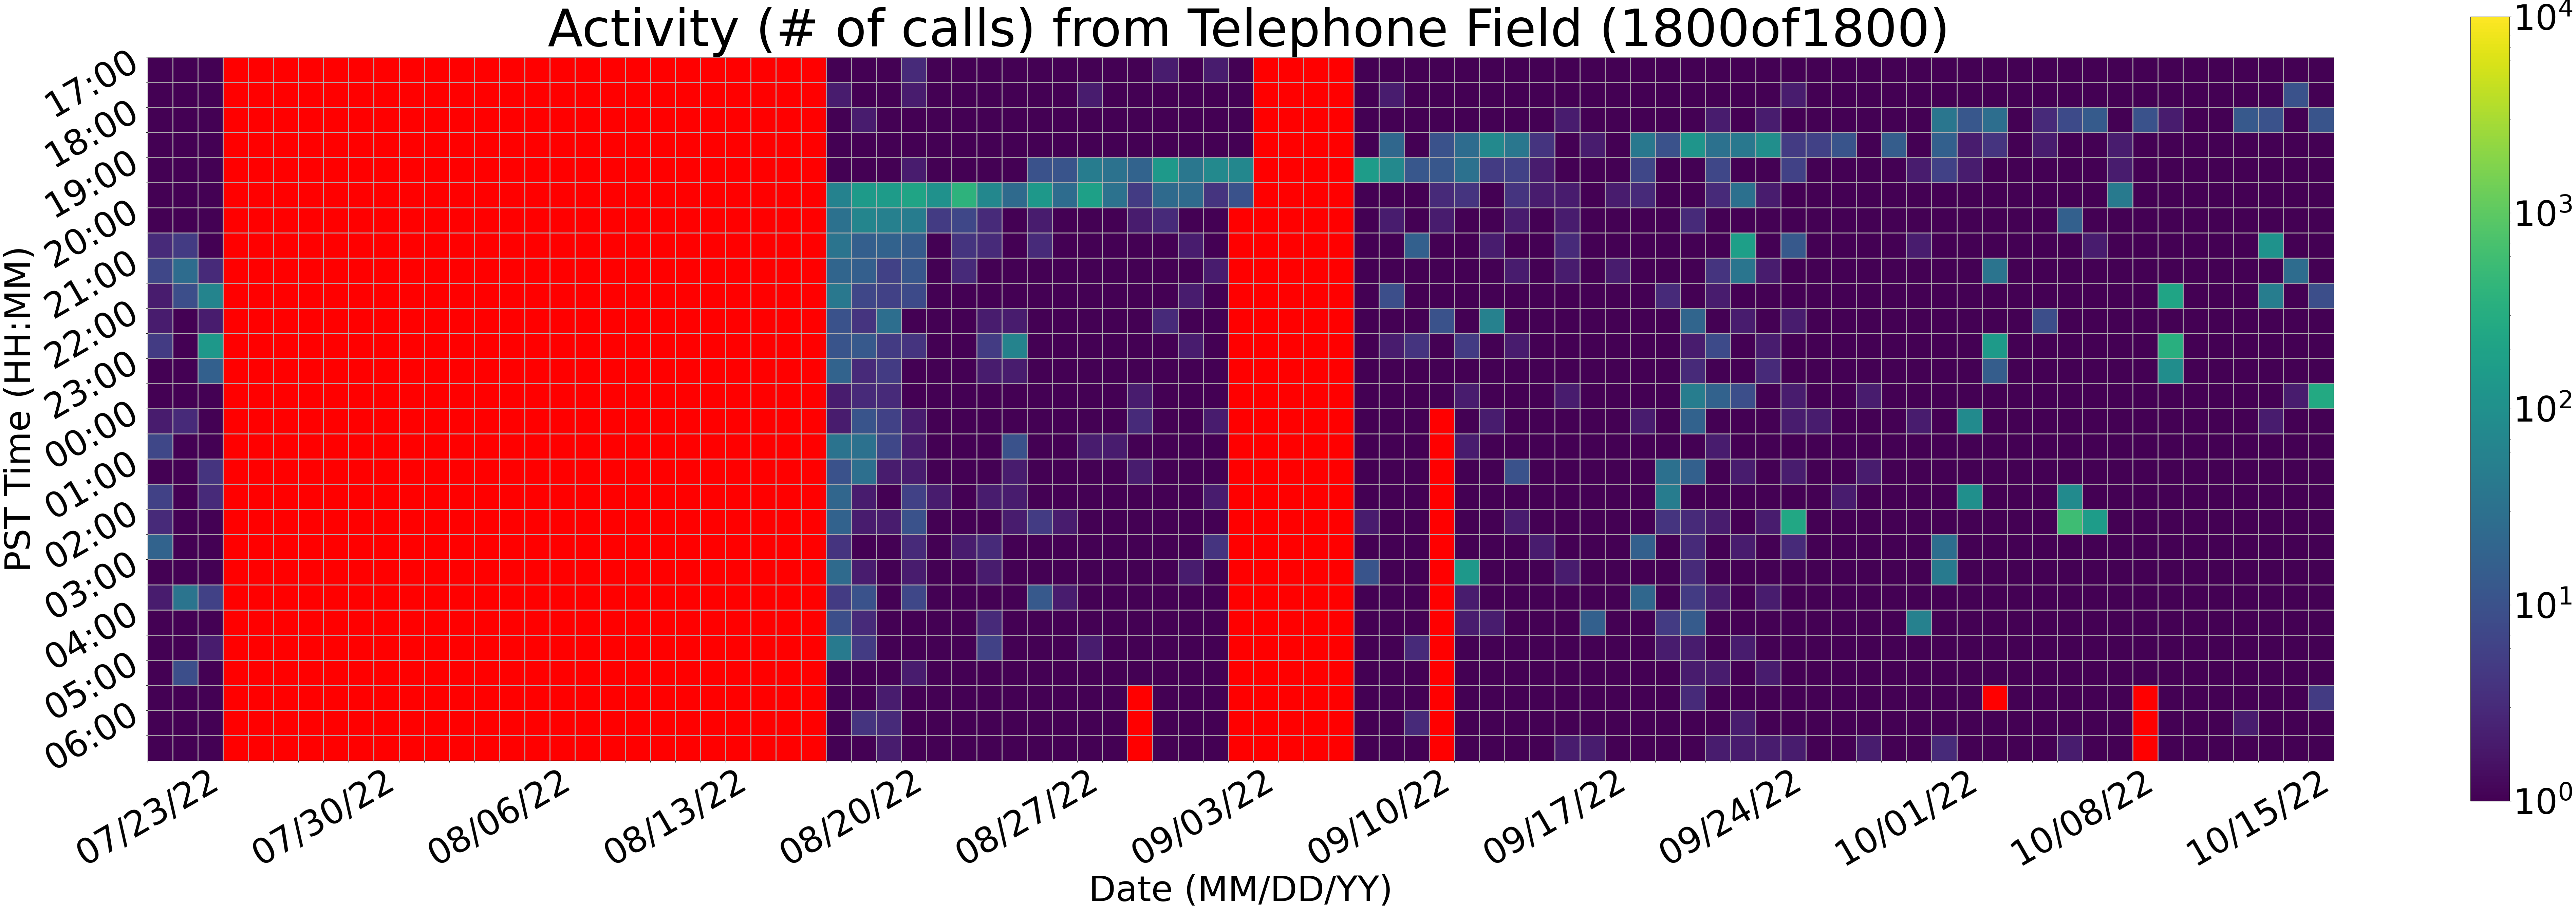

In [12]:
plot.plot_activity_grid_for_dets(activity_dets_arr, data_params, pipeline_params, file_paths)